## Methods Comparison for Assessing Population Structure
Alexander Eyre (2022)
____
This project will make use of a merged dataset containing only Labrador Retrievers from the following studies (all merged to the CanFam3.1 dog genome assembly).  This dataset was made in 2020 and the scripts used are not yet knit into a pipeline for usage with other datasets.  If there is interest in immediate development of the dataset merging pipeline or possible collaboration, please message me.  Otherwise, it is considered fairly low priority until needed again.

These results contain conflicting individuals between datasets and should not be considered for publication purposes.  Both the genotype merging pipeline and population structure pipeline are meant to be proofs of concept.  Data will not yet be made public due to permissions.

Studies included:

Eyre, A.W., Zapata, I., Hare, E. et al. Genome scanning of behavioral selection in a canine olfactory detection breeding cohort. Sci Rep 12, 14984 (2022). https://doi.org/10.1038/s41598-022-18698-4

Hayward, J., Castelhano, M., Oliveira, K. et al. Complex disease and phenotype mapping in the domestic dog. Nat Commun 7, 10460 (2016). https://doi.org/10.1038/ncomms10460

Vaysse A, Ratnakumar A, Derrien T, et al. Identification of genomic regions associated with phenotypic variation between dog breeds using selection mapping. PLoS Genet. 2011 Oct;7(10):e1002316. doi: 10.1371/journal.pgen.1002316. Epub 2011 Oct 13. PMID: 22022279; PMCID: PMC3192833.

An unpublished cohort from Seeing Eye

____
Principal Component Analysis (PCA):  Linear Analysis that uses eigenanalysis to produce vectors called principal components, where each component captures the axis of maximum variance in the data while being orthogonal to the previous components.

Multidimensional Scaling (MDS):  First, the pairwise distances between each pair of samples in the original space are calculated. Next, a projection to the low-dimensional space is learned by minimizing the differences between the pairwise distances in the lowdimensional space and the calculated distances in the original space. MDS has largely been superseded by other distance-based methods.

t-distributed Stochastic Neighbor Embedding (t-SNE):  This technique aims to reconstruct the graph in a lower-dimensional space, while maintaining the topological structure from the original high-dimensional space.

Uniform Manifold Approximation and Projection (UMAP):  This technique aims to reconstruct the graph in a lower-dimensional space, while maintaining the topological structure from the original high-dimensional space.

Autoencoders (AE):  Neural network that is commonly used for learning a set of features from data in an unsupervised fashion. The encoder network 'fencoder' compresses the highdimensional input x into a lower-dimensional space, while the
decoder network 'fdecoder' outputs an approximation x^ of the original input using only the low-dimensional embedding provided by the encoder. Since the embedding space acts as a bottleneck, it must efficiently represent as much of the relevant information as possible from the original signal. For this reason, AEs have often been used as a means of extracting informative and discriminative features for downstream tasks, where the embedding representation can be re-used for another purpose.

Variational Autoencoders (VAE):   Latent variable model that defines a generative model over data.  Are trained using stochastic sampling.  VAEs and their many variants are useful models because the posterior density of the model approximates the tractable prior. This means that sampling new data from the complex, multi-modal data distribution is as simple as sampling from the known prior. It also means that, unlike with the AE, the density of the posterior is approximately continuous in the latent space and so it is often possible to smoothly interpolate between points in this space.

Motivation and Methods Descriptions:  Ubbens J, Feldmann MJ, Stavness I, Sharpe AG. Quantitative evaluation of nonlinear methods for population structure visualization and inference. G3 (Bethesda). 2022 Aug 25;12(9):jkac191. doi: 10.1093/g3journal/jkac191. PMID: 35900169; PMCID: PMC9434256.

____
### Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import pytorch_lightning as pl
plt.style.use('seaborn-darkgrid')

# Data Preparation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Analyses
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from umap import UMAP
from torch.utils.data import TensorDataset, DataLoader

# Written Python Scripts
from ae_model import autoencoder
from vae_model import VAE

____
### Define Functions

In [2]:
def imputer(dataset):
    imp = IterativeImputer(max_iter = 500, random_state = 101)
    imp.fit(dataset)
    curr_data = imp.transform(dataset)
    return pd.DataFrame(curr_data, columns = dataset.columns)

____
### Data Import
The genotype data to be used in this project should be in the PLINK .raw format.  This can be generated using PLINK's --recodeA command.

In [3]:
# QC & Pruned Dataset
all_data             = pd.read_csv("MasterLabs_pruned.raw", 
                                   delimiter = " ",
                                   low_memory = False)
geno_data            = all_data.iloc[:,6:]

In [4]:
# Dog Information
dog_info             = list(all_data.iloc[:,0])

____
### Data Preparation

In [5]:
# Impute missing genotypes

idx                 = 0 
chunk_size          = 100
test                = False

while idx < len(geno_data.columns):
    geno_data.iloc[:,idx:idx+chunk_size] = imputer(geno_data.iloc[:,idx:idx+chunk_size]).round(decimals = 0)
    
    if test == True:
        idx = len(geno_data.columns) + 1
    elif idx + chunk_size >= len(geno_data.columns):
        test = True
        idx = len(geno_data.columns) - 1
    else:
        idx = idx + chunk_size        

____
### Analyses
Select genotype dataset

Select colorization scheme

In [6]:
# Select Dataset
curr_data            = geno_data

# Select Colorization Scheme
curr_color           = dog_info

____
#### Principal Component Analysis (PCA)

In [7]:
# Run PCA
pca            = PCA(n_components = 100,
                     random_state = 101)
curr_pca       = pca.fit_transform(curr_data)

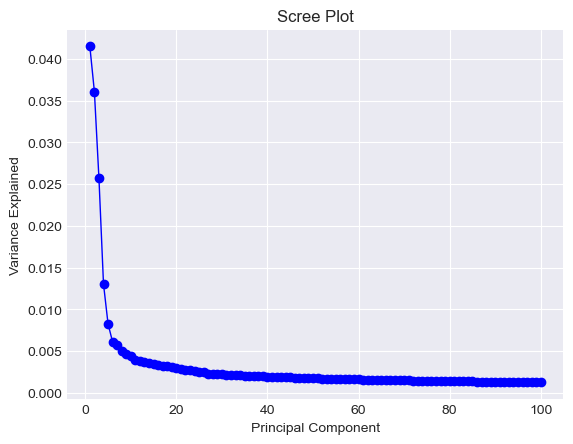

In [8]:
# Scree Plot
PC_values      = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [9]:
# Setup the top two components for the PCA
i   = 0
PC1 = []
PC2 = []
while i < len(curr_pca):
    PC1.append(curr_pca[i][0])
    PC2.append(curr_pca[i][1])
    i = i + 1

Text(0, 0.5, 'PC2')

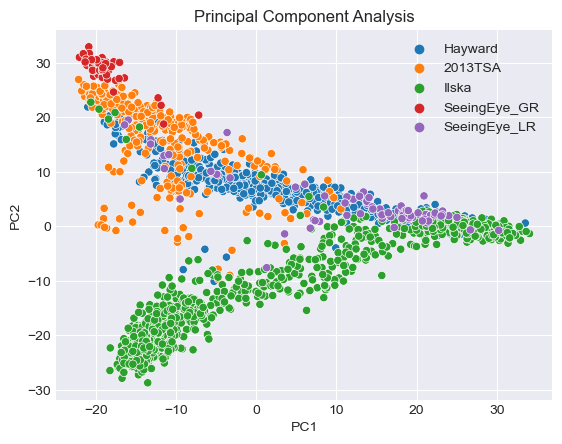

In [10]:
# Plot the top two components against eachother
sns.scatterplot(x = PC1, 
                y = PC2, 
                hue = curr_color)
plt.title("Principal Component Analysis")
plt.xlabel("PC1")
plt.ylabel("PC2")

____
#### Multidimensional Scaling (MDS)

In [11]:
# Run MDS
mds            = MDS(n_components = 2,
                     max_iter = 300,
                     eps = 1e-3,
                     random_state = 101)
curr_mds       = mds.fit_transform(curr_data)

In [12]:
# Setup X and Y values for plot
i              = 0
mds_X          = []
mds_Y          = []
while i < len(curr_mds):
    mds_X.append(curr_mds[i][0])
    mds_Y.append(curr_mds[i][1])
    i = i + 1

Text(0, 0.5, 'Dimension 2')

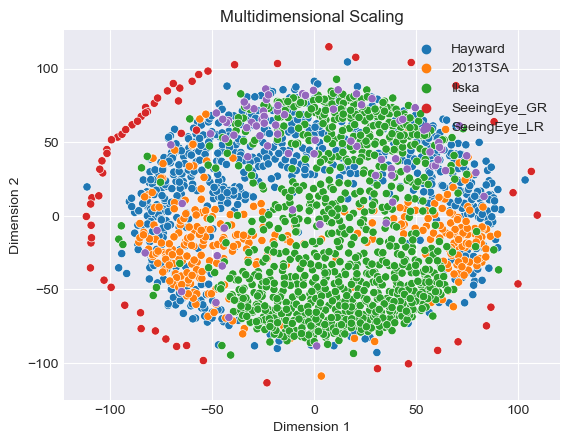

In [13]:
# Plot MDS
sns.scatterplot(x = mds_X, 
                y = mds_Y, 
                hue = curr_color)
plt.title("Multidimensional Scaling")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

____
#### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [14]:
tsne           = TSNE(n_components = 2,
                      perplexity = 30,
                      early_exaggeration = 12,
                      learning_rate = 200,
                      n_iter = 1000,
                      n_iter_without_progress = 300,
                      min_grad_norm = 1e-7,
                      metric = 'euclidean',
                      init = 'random',
                      random_state = 101)
curr_tsne      = tsne.fit_transform(curr_data)

In [15]:
# Setup X and Y values for plot
i              = 0
tsne_X         = []
tsne_Y         = []
while i < len(curr_tsne):
    tsne_X.append(curr_tsne[i][0])
    tsne_Y.append(curr_tsne[i][1])
    i = i + 1

Text(0, 0.5, 'Dimension 2')

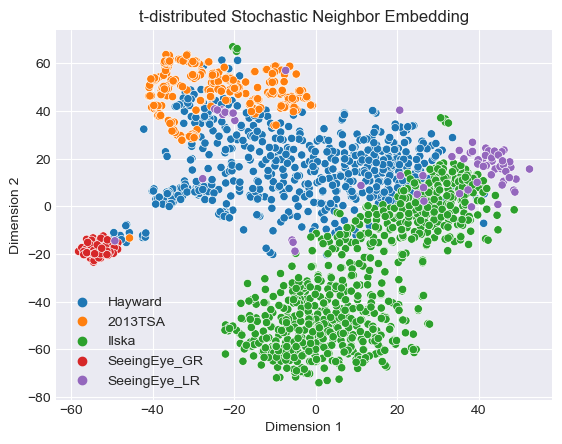

In [16]:
# Plot tSNE
sns.scatterplot(x = tsne_X, 
                y = tsne_Y, 
                hue = curr_color)
plt.title("t-distributed Stochastic Neighbor Embedding")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

____
#### Uniform Manifold Approximation and Projection (UMAP)

In [17]:
umap           = UMAP(n_components = 2,
                      init = 'random',
                      random_state = 101)
curr_umap      = umap.fit_transform(curr_data)

In [18]:
# Setup X and Y values for plot
i              = 0
umap_X         = []
umap_Y         = []
while i < len(curr_umap):
    umap_X.append(curr_umap[i][0])
    umap_Y.append(curr_umap[i][1])
    i = i + 1

Text(0, 0.5, 'Dimension 2')

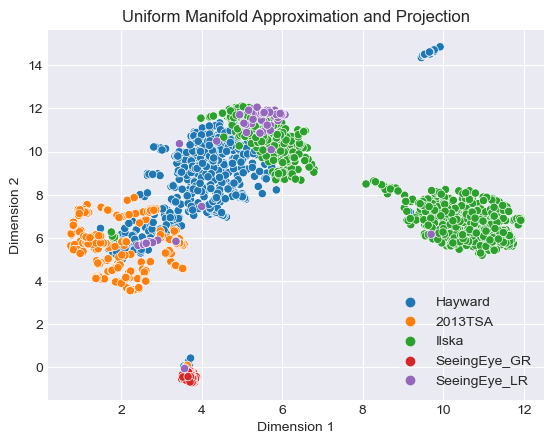

In [19]:
# Plot UMAP
sns.scatterplot(x = umap_X, 
                y = umap_Y, 
                hue = curr_color)
plt.title("Uniform Manifold Approximation and Projection")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

____
#### Deep Learning Methods

In [20]:
tensor_data    = torch.tensor(np.array(curr_data), dtype = torch.float32)

____
#### Autoencoders (AE)

In [21]:
dataloader     = DataLoader(tensor_data,
                            batch_size = 16,
                            drop_last = False,
                            shuffle = True,
                            num_workers = 8)
ae             = autoencoder(num_channels = 1,
                             sample_size = tensor_data.shape[1],
                             categorical = False,
                             hyperparams = {'d' : 2, 'hidden_dims': [256, 128]})
trainer        = pl.Trainer(devices = 1,
                            max_epochs = 100,
                            accelerator = 'gpu')
trainer.fit(ae, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\aweyr\OneDrive\Documents\AlvarezLab\ClassCompare\2013TSA Analysis\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | encoder     | Sequential | 4.3 M 
1 | decoder     | Sequential | 33.4 K
2 | final_layer | Sequential | 4.3 M 
-------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params
34.589    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [22]:
dataloader     = DataLoader(tensor_data,
                            batch_size = 16,
                            drop_last = False,
                            shuffle = False,
                            num_workers = 8)
ae_embs        = ae.get_all_embeddings(dataloader)

Text(0, 0.5, 'Dimension 2')

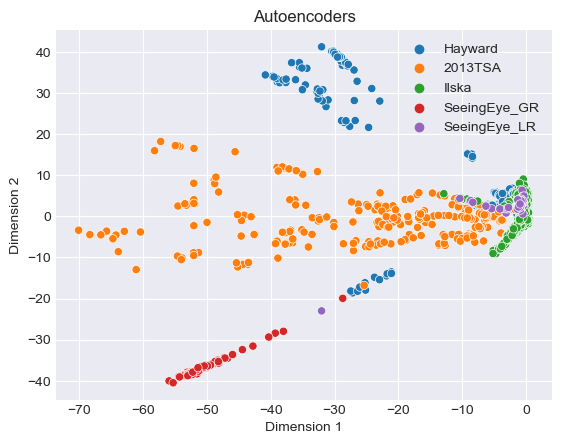

In [23]:
sns.scatterplot(x = ae_embs[:, 0], 
                y = ae_embs[:, 1], 
                hue = curr_color)
plt.title("Autoencoders")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

____
#### Variational Encoders (VAE)

In [24]:
dataloader     = DataLoader(tensor_data,
                            batch_size = 16,
                            drop_last = True,
                            shuffle = True,
                            num_workers = 8)
vae            = VAE(num_channels = 1,
                     sample_size = tensor_data.shape[1],
                     categorical = False,
                     hyperparams = {'d': 2, 'kld_weight': 1., 'hidden_dims': [128, 64, 32, 16, 8, 4], 'kld_annealing': False})
trainer        = pl.Trainer(devices = 1,
                            max_epochs = 100,
                            accelerator = 'gpu')
trainer.fit(vae, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | encoder     | Sequential | 2.2 M 
1 | fc_mu       | Linear     | 10    
2 | fc_var      | Linear     | 10    
3 | decoder     | Sequential | 11.7 K
4 | final_layer | Sequential | 2.2 M 
-------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.288    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [25]:
dataloader     = DataLoader(tensor_data,
                            batch_size = 16,
                            drop_last = False,
                            shuffle = False,
                            num_workers = 8)
vae_embs       = vae.get_all_embeddings(dataloader)

Text(0, 0.5, 'Dimension 2')

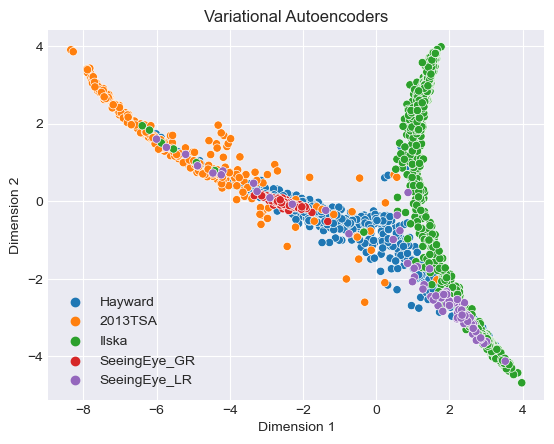

In [26]:
sns.scatterplot(x = vae_embs[:, 0], 
                y = vae_embs[:, 1], 
                hue = curr_color)
plt.title("Variational Autoencoders")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")